In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchvision.utils import save_image
from torchsummary import summary

from random import randint
from tqdm import tqdm

from IPython.display import Image
from IPython.core.display import Image, display

/var/folders/pj/m2_5zytd5p715tv2nwwfg3pc0000gp/T/ipykernel_91726/2062885581.py:16: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import Image, display


In [12]:
# device = torch.device('cpu')
device = torch.device("cpu")

In [6]:
batch_size = 32

# Load Data
dataset = datasets.ImageFolder(
    root="./frames",
    transform=transforms.Compose(
        [
            transforms.Resize(256),
            transforms.ToTensor(),
        ]
    ),
)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)
len(dataset.imgs), len(dataloader)

(128642, 4021)

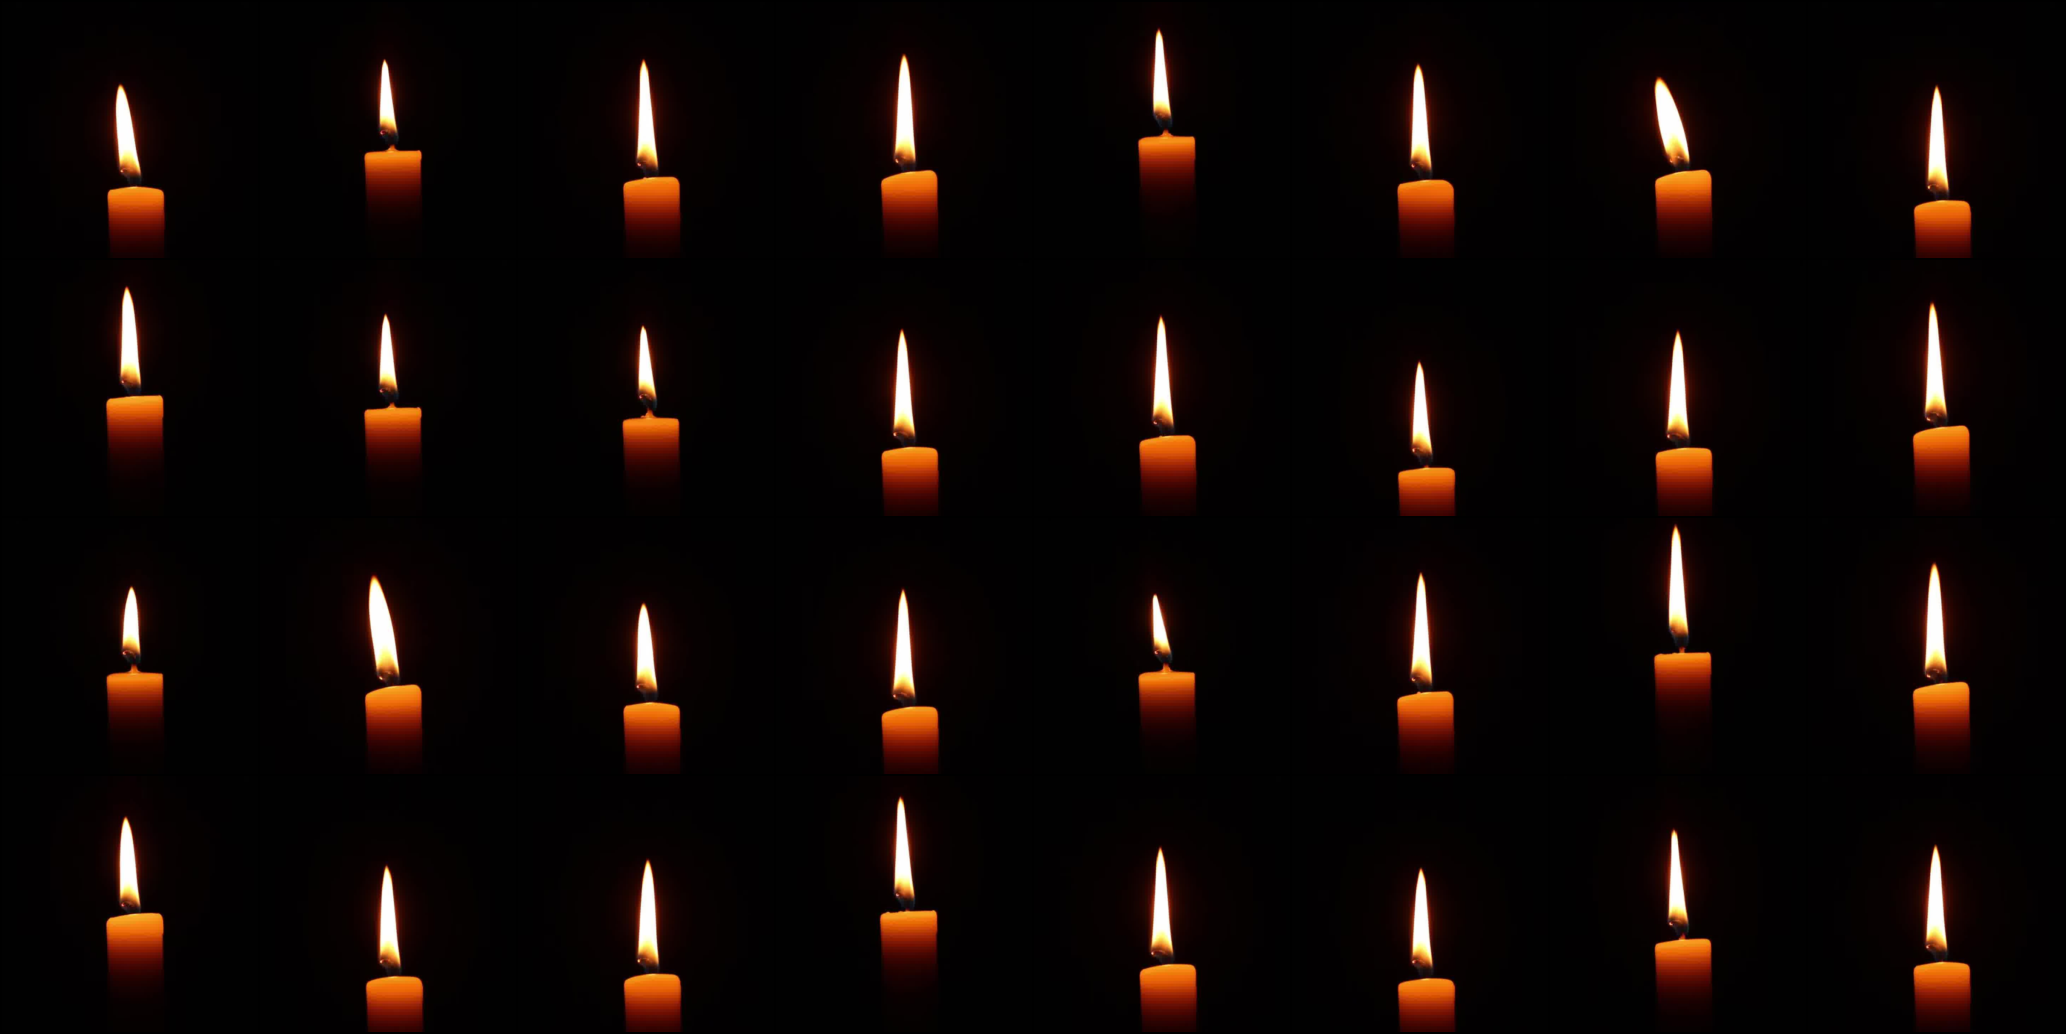

In [7]:
fixed_x, _ = next(iter(dataloader))
save_image(fixed_x, "real_image.png")

Image("real_image.png")

In [13]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class UnFlatten(nn.Module):
    def __init__(self, size=1024):
        super(UnFlatten, self).__init__()
        self.size = size

    def forward(self, input):
        return input.view(input.size(0), self.size, 1, 1)


class VAE(nn.Module):
    def __init__(self, image_channels=3, h_dim=1024, z_dim=2):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(image_channels, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=4, stride=2),
            nn.ReLU(),
            Flatten(),
        )

        self.fc1 = nn.Linear(h_dim, z_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(z_dim, h_dim)

        self.decoder = nn.Sequential(
            UnFlatten(size=h_dim),
            nn.ConvTranspose2d(h_dim, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 64, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, kernel_size=5, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 32, kernel_size=6, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(32, image_channels, kernel_size=6, stride=2),
            nn.Sigmoid(),
        )

    def reparameterize(self, mu, logvar):
        std = logvar.mul(0.5).exp_()
        esp = torch.randn(*mu.size())
        z = mu + std * esp
        return z

    def bottleneck(self, h):
        mu, logvar = self.fc1(h), self.fc2(h)
        z = self.reparameterize(mu, logvar)
        return z, mu, logvar

    def encode(self, x):
        h = self.encoder(x)
        z, mu, logvar = self.bottleneck(h)
        return z, mu, logvar

    def decode(self, z):
        z = self.fc3(z)
        z = self.decoder(z)
        return z

    def forward(self, x):
        z, mu, logvar = self.encode(x)
        z = self.decode(z)
        return z, mu, logvar

In [14]:
latent_size = 512

image_channels = fixed_x.size(1)
model = VAE(image_channels=image_channels, h_dim=latent_size).to(device)
summary(model.encoder, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]           1,568
              ReLU-2         [-1, 32, 127, 127]               0
            Conv2d-3           [-1, 32, 62, 62]          16,416
              ReLU-4           [-1, 32, 62, 62]               0
            Conv2d-5           [-1, 64, 30, 30]          32,832
              ReLU-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 14, 14]         131,200
              ReLU-8          [-1, 128, 14, 14]               0
            Conv2d-9            [-1, 128, 6, 6]         262,272
             ReLU-10            [-1, 128, 6, 6]               0
           Conv2d-11            [-1, 128, 2, 2]         262,272
             ReLU-12            [-1, 128, 2, 2]               0
          Flatten-13                  [-1, 512]               0
Total params: 706,560
Trainable params:

In [15]:
summary(model.decoder, (latent_size,))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         UnFlatten-1            [-1, 512, 1, 1]               0
   ConvTranspose2d-2             [-1, 64, 5, 5]         819,264
              ReLU-3             [-1, 64, 5, 5]               0
   ConvTranspose2d-4           [-1, 64, 13, 13]         102,464
              ReLU-5           [-1, 64, 13, 13]               0
   ConvTranspose2d-6           [-1, 64, 29, 29]         102,464
              ReLU-7           [-1, 64, 29, 29]               0
   ConvTranspose2d-8           [-1, 32, 61, 61]          51,232
              ReLU-9           [-1, 32, 61, 61]               0
  ConvTranspose2d-10         [-1, 32, 126, 126]          36,896
             ReLU-11         [-1, 32, 126, 126]               0
  ConvTranspose2d-12          [-1, 3, 256, 256]           3,459
          Sigmoid-13          [-1, 3, 256, 256]               0
Total params: 1,115,779
Trainable param

In [16]:
summary(model, (3, 256, 256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 127, 127]           1,568
              ReLU-2         [-1, 32, 127, 127]               0
            Conv2d-3           [-1, 32, 62, 62]          16,416
              ReLU-4           [-1, 32, 62, 62]               0
            Conv2d-5           [-1, 64, 30, 30]          32,832
              ReLU-6           [-1, 64, 30, 30]               0
            Conv2d-7          [-1, 128, 14, 14]         131,200
              ReLU-8          [-1, 128, 14, 14]               0
            Conv2d-9            [-1, 128, 6, 6]         262,272
             ReLU-10            [-1, 128, 6, 6]               0
           Conv2d-11            [-1, 128, 2, 2]         262,272
             ReLU-12            [-1, 128, 2, 2]               0
          Flatten-13                  [-1, 512]               0
           Linear-14                   

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

In [18]:
def loss_fn(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x, size_average=False)
    # BCE = F.mse_loss(recon_x, x, size_average=False)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD, BCE, KLD

In [ ]:
epochs = 28

for epoch in tqdm(range(epochs)):
    for idx, (images, _) in tqdm(enumerate(dataloader)):
        recon_images, mu, logvar = model(images)
        loss, bce, kld = loss_fn(recon_images, images, mu, logvar)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        to_print = "Epoch[{}/{}] Loss: {:.3f} {:.3f} {:.3f}".format(
            epoch + 1,
            epochs,
            loss.item() / batch_size,
            bce.item() / batch_size,
            kld.item() / batch_size,
        )
        if idx % 100 == 0:
            torch.save(model.state_dict(), "vae_candle_256.torch")
        print(to_print)

    torch.save(model.state_dict(), "vae_candle_256.torch")

In [19]:
model.load_state_dict(torch.load("vae_candle_256.torch", map_location="cpu"))

<All keys matched successfully>

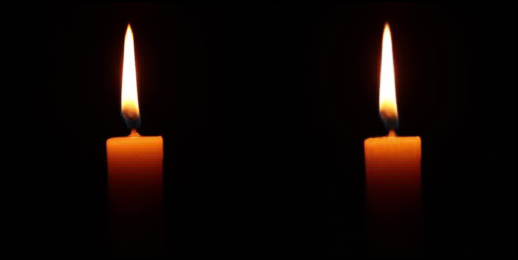

In [21]:
def compare(x):
    recon_x, _, _ = model(x)
    return torch.cat([x, recon_x])


fixed_x = dataset[randint(1, 10000)][0].unsqueeze(0)
compare_x = compare(fixed_x)

save_image(compare_x.data.cpu(), "sample_image.png")
display(Image("sample_image.png", width=700, unconfined=True))

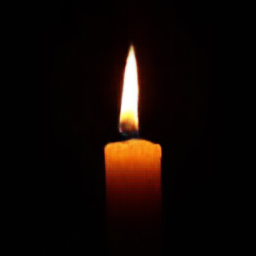

In [22]:
x_reconstructed = model.decode(torch.tensor([[2.0, 4.0]]))

save_image(x_reconstructed.data.cpu(), "sample_image.png")
display(Image("sample_image.png", width=500, unconfined=True))

In [24]:
import os

filenames = os.listdir("frames/candle")
filenames = sorted(filenames)
filenames[0]

'output_000001.jpg'

In [25]:
from PIL import Image as PImage
import numpy as np


def load_image(filename):
    img = PImage.open("frames/candle/" + filename)
    img = img.resize((256, 256))
    img = np.array(img)
    img = img / 255.0
    return img

In [69]:
mus_buffer = []
inds_sample = np.random.choice(len(filenames) // 32, 1000)
for i in tqdm(inds_sample):
    a, b = i * 32, (i + 1) * 32
    images = []
    for j in range(a, b):
        filename = "output_{:06d}.jpg".format(j + 1)
        img = load_image(filename)
        images.append(img)
    image_tensor = torch.tensor(images, dtype=torch.float32).permute(0, 3, 1, 2)
    zs, mus, log_vars = model.encode(image_tensor)
    mus_buffer.append(mus.detach().numpy())
mus = np.concatenate(mus_buffer)

100%|██████████| 1000/1000 [35:32<00:00,  2.13s/it]


In [70]:
from scipy.optimize import least_squares


def fun(params, x, y):
    x0, y0, r = params
    return (x - x0) ** 2 + (y - y0) ** 2 - r**2


x = mus[:, 0]
y = mus[:, 1]

params0 = [1, 1, 1]
res = least_squares(fun, params0, args=(x, y))
R_circ = res.x
R_circ

array([-0.01092171,  0.10167154,  2.18102396])

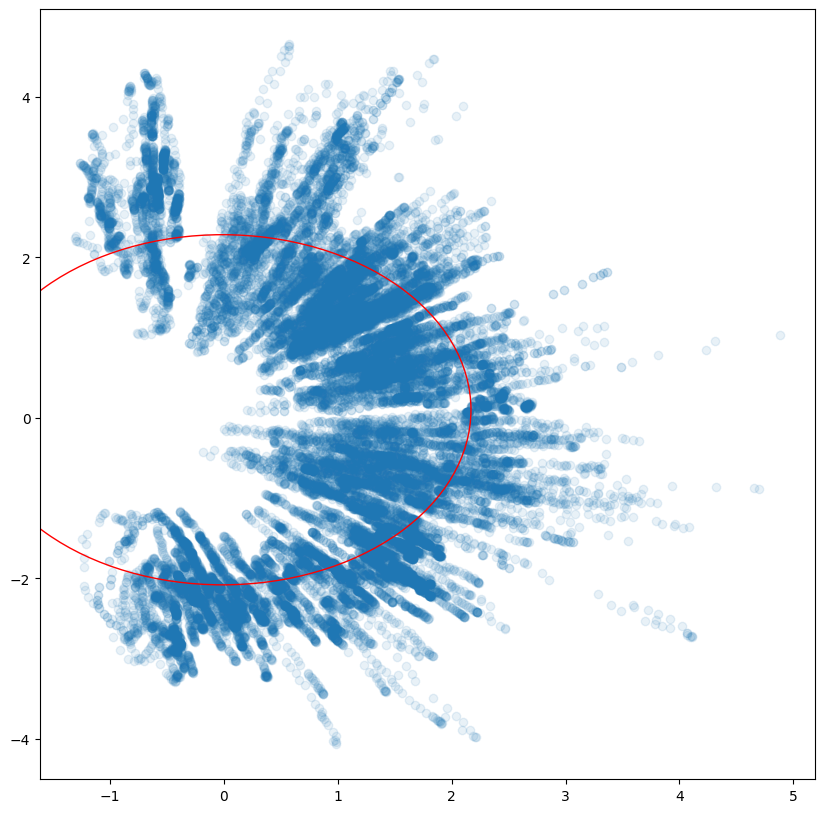

In [71]:
from matplotlib import pyplot as plt

plt.figure(figsize=(10, 10))
plt.scatter(x, y, alpha=0.1)
circle = plt.Circle((R_circ[0], R_circ[1]), R_circ[2], color="r", fill=False)
plt.gca().add_artist(circle)
plt.show()

In [50]:
!mkdir gif

mkdir: gif: File exists


In [72]:
def harmonic_oscillator(mu_z1, mu_z2, d, z1_circ, z2_circ, t):
    z1 = mu_z1 + d * np.sin(t) * (z1_circ - mu_z1)
    z2 = mu_z2 + d * np.sin(t) * (z2_circ - mu_z2)
    return z1, z2


def create_sequence(mu_z1, mu_z2, d, z1_circ, z2_circ, frames_cnt):
    z1_buffer = []
    z2_buffer = []
    for i in range(frames_cnt):
        t = 2 * np.pi * i / frames_cnt
        z1, z2 = harmonic_oscillator(mu_z1, mu_z2, d, z1_circ, z2_circ, t)
        z1_buffer.append(z1)
        z2_buffer.append(z2)
    z1 = np.array(z1_buffer)
    z2 = np.array(z2_buffer)
    return z1, z2


t = 0.0
z1_circ, z2_circ, R_circ = -0.01092171,  0.10167154,  2.18102396
mu_z1 = z1_circ + R_circ * np.sin(2 * np.pi * t)
mu_z2 = z2_circ + R_circ * np.cos(2 * np.pi * t)

z1_buffer = []
z2_buffer = []
z1, z2 = create_sequence(mu_z1, mu_z2, R_circ * 0.1, z1_circ, z2_circ, 100)

frames_cnt = len(z1)
# z1 = z1 + np.random.normal(0, 0.01, frames_cnt)
# z2 = z2 + np.random.normal(0, 0.01, frames_cnt)

for i in tqdm(range(frames_cnt)):
    z = torch.tensor([[z1[i], z2[i]]], dtype=torch.float32)
    x_reconstructed = model.decode(z)
    save_image(x_reconstructed.data.cpu(), "gif/{:05d}.png".format(i))

100%|██████████| 100/100 [00:02<00:00, 36.26it/s]


Text(0.5, 0, 'z1')

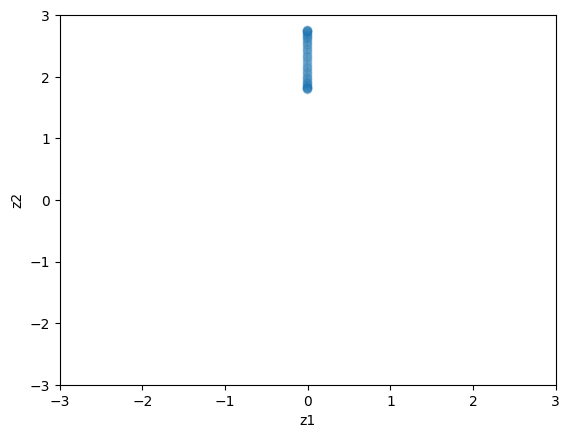

In [73]:
import matplotlib.pyplot as plt

plt.plot(z1, z2, "o-", alpha=0.1)
plt.xlim(-3, 3)
plt.ylim(-3, 3)
plt.ylabel("z2")
plt.xlabel("z1")

In [74]:
import imageio

frames = []
for t in tqdm(range(frames_cnt)):
    image = imageio.v2.imread("gif/{:05d}.png".format(t))
    frames.append(image)

imageio.mimsave("./example.gif", frames, duration=1.0 / 20, loop=0)

100%|██████████| 100/100 [00:00<00:00, 552.06it/s]
